# Project 2

# Задание 1. A/B-test

### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

- **groups.csv** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) \
- **groups_add.csv** - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных \
- **active_studs.csv** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента \
- **checks.csv** - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.3 Вопросы

**Предлагаем Вам ответить на следующие вопросы:**

- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?

### 1.4 Решение

#### Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
import math

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from tqdm.auto import tqdm
plt.style.use('ggplot')

from datetime import datetime
from datetime import timedelta
from urllib.parse import urlencode
import json
import urllib
from calendar import monthrange
from operator import attrgetter

import io
import requests

### 1) Используем API и загружаем csv файлы с яндекс диска

Используем api 

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
public_key_groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
public_key_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
public_key_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

Получаем url

In [3]:
final_url_1 = base_url + urlencode(dict(public_key=public_key_groups)) 
response_1 = requests.get(final_url_1)
download_url_1 = response_1.json()['href']

final_url_2 = base_url + urlencode(dict(public_key=public_key_groups_add)) 
response_2 = requests.get(final_url_2)
download_url_2 = response_2.json()['href']

final_url_3 = base_url + urlencode(dict(public_key=public_key_active_studs)) 
response_3 = requests.get(final_url_3)
download_url_3 = response_3.json()['href']

final_url_4 = base_url + urlencode(dict(public_key=public_key_checks)) 
response_4 = requests.get(final_url_4)
download_url_4 = response_4.json()['href']

Загружаем файлы и формируем датафреймы 

In [4]:
download_response = requests.get(download_url_1) 
groups = pd.read_csv(download_url_1, sep=';')
download_response = requests.get(download_url_2)
groups_add = pd.read_csv(download_url_2)
download_response = requests.get(download_url_3)
active_studs = pd.read_csv(download_url_3)
checks = pd.read_csv(download_url_4, sep=';')
download_response = requests.get(download_url_4)

### 2) Проверим запись данных, соответствие типов данных и отсутствие null значений

In [5]:
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


Видим, что типы данных соответствуют значениям в колонках. Также, видим, что количество не null значений совпадает с кол-вом строк в датафрейме, что значит отсутствие null значений. Проделаем схожие операции с другими df

In [6]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


Проверим на дубликаты

In [7]:
if groups.nunique()[0] < groups.shape[0]:
    print('Дубликаты есть')
else: print('Дубликатов нет')

Дубликатов нет


Проверяем, есть ли отсутствующие значения

In [341]:
groups.isna().any()

id     False
grp    False
dtype: bool

Проверим следующий датафрейм groups_add

In [8]:
groups_add.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


Здесь все хорошо, замечаний нет

In [9]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [10]:
if groups_add.nunique()[0] < groups_add.shape[0]:
    print('Дубликаты есть')
else: print('Дубликатов нет')

Дубликатов нет


Проверяем, есть ли отсутствующие значения

In [340]:
groups_add.isna().any()

id     False
grp    False
dtype: bool

Проверим следующий датафрейм active_studs

In [11]:
active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


Здесь все хорошо, замечаний нет

In [12]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [13]:
if active_studs.nunique()[0] < active_studs.shape[0]:
    print('Дубликаты есть')
else: print('Дубликатов нет')

Дубликатов нет


Проверяем, есть ли отсутствующие значения

In [339]:
active_studs.isna().any()

id     False
exp    False
dtype: bool

Проверим последний датафрейм

In [14]:
checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


Здесь также все хорошо, замечаний нет. На всякий случай можно проверить отсутствие null значений методом isna()

In [15]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [16]:
if checks.nunique()[0] < checks.shape[0]:
    print('Дубликаты есть')
else: print('Дубликатов нет')

Дубликатов нет


Проверяем, есть ли отсутствующие значения

In [17]:
checks.isna().any()

student_id    False
rev           False
dtype: bool

### 3) Итак, с данными все хорошо. Подготовим датафрейм к анализу

Соединим (concatenate) датафреймы groups_add, который прислали позже и датафрейм groups

In [18]:
groups_full = pd.concat([groups, groups_add], ignore_index=True, axis=0)

In [19]:
groups_full.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


74484 строки (groups) + 92 строки (groups_add) = 74576

In [20]:
groups_full.shape

(74576, 2)

Проверим наличие дубликатов

In [21]:
if groups_full.nunique()[0] < groups_full.shape[0]:
    groups_full = groups_full.drop_duplicates(subset=['id', 'grp'])
    print('Дубликаты есть')
else: print('Дубликатов нет')

Дубликатов нет


Изменим имена колонок в active_studs и checks, а затем проверим, что в full_group содержатся все студенты из датафреймов active_studs и checks

In [22]:
active_studs = active_studs.rename(columns={'student_id':'id'})

In [23]:
checks = checks.rename(columns={'student_id':'id'})

Проверим, что в full_group содержатся все студенты из датафреймов active_studs и checks

In [24]:
if groups_full.merge(active_studs, how='inner', on='id').nunique()[0] == active_studs.id.nunique():
    print('Значения есть в обоих датафреймах')
else: print('Некоторых значений нет в groups_full, которые есть в active_studs')

Значения есть в обоих датафреймах


In [25]:
if groups_full.merge(checks, how='inner', on='id').nunique()[0] == checks.id.nunique():
    print('Значения есть в обоих датафреймах')
else: print('Некоторых значений нет в groups_full, которые есть в active_studs')

Значения есть в обоих датафреймах


Создадим колонку exp_participated, в которой укажем значения: \
- 0 - не учавствовал в эксперименте
- 1 - учавтсвовал в эксперименте

In [26]:
active_studs['exp_participated'] = 1

Сджоиним все датафреймы

In [27]:
groups_merged = groups_full \
    .merge(active_studs, how='left', on='id').fillna(0) \
    .merge(checks, how='left', on='id').fillna(0)

Итак, наш датафрейм готов к анализу

In [28]:
groups_merged

,id,grp,exp_participated,rev
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0
...,...,...,...,...
74571,200247820,B,0.0,0.0
74572,201032527,B,0.0,0.0
74573,201067612,B,0.0,0.0
74574,201067653,B,0.0,0.0


### 4) Проверим датафрейм на аномалии

Проверим, имеются ли пользователи, которые совершили покупку, но не заходили на платформу в дни проведения эксперимента

Видим, что такие пользователи есть

In [29]:
groups_merged.query('exp_participated == 0 and rev > 0').id.count()

149

Посчитаем, какое количество таких пользователей в датафрейме по отношению ко всем пользователям, которые совершили покупку

Видим, что около 30% пользователей сделали покупку, но не заходили на платформу в этот день

In [30]:
round(149 / groups_merged[groups_merged['rev'] > 0].id.count() * 100, 1)

27.5

Причиной такой аномалии может быть:
1) Ошибка в алгоритме / коде, и на самом деле они заходили на сайт, но данные считались неверно \
2) Возможно деньги списываются платформой каждый месяц у некоторых пользователей, и с данными все впорядке

#### Будем считать, что произошла ошибка при записи данных, и эти пользователи все-таки зашли на платформу для совершения оплаты

Добавим колонку с данными о том, сделал пользователь покупку или нет

In [31]:
groups_merged['made_purchase'] = groups_merged.rev > 0

In [32]:
groups_merged.head(3)

,id,grp,exp_participated,rev,made_purchase
0,1489,B,0.0,0.0,False
1,1627,A,1.0,990.0,True
2,1768,B,0.0,0.0,False


### 5) Определение основных метрик

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Проверим, отличаются ли значения следующих метрик:

- средний чек (avprice),
- общее количество заказов,
- ARPU,
- ARPPU,
- конверсия в покупку (CR).

Запишем пользователей контрольной и тестовой групп для удобства расчетов

In [33]:
group_control = groups_merged[groups_merged['grp'] == 'A']
group_test = groups_merged[groups_merged['grp'] == 'B']

Запишем пользователей, которые участвовали в эксперименте, в соответствующие группы для удобства расчетов

In [34]:
group_control_exp = groups_merged[groups_merged['grp'] == 'A'].query('exp_participated == 1')
group_test_exp = groups_merged[groups_merged['grp'] == 'B'].query('exp_participated == 1')

**Считаем средний чек**

In [35]:
avg_check_control = group_control[group_control['rev'] > 0].rev.mean() # контрольная группа

In [36]:
avg_check_test = group_test[group_test['rev'] > 0].rev.mean() # тестовая группа

In [37]:
avg_check_control_exp = group_control_exp[group_control_exp['rev'] > 0].rev.mean() # контрольная группа (эксперимент)

In [38]:
avg_check_test_exp = group_test_exp[group_test_exp['rev'] > 0].rev.mean() # тестовая группа (эксперимент)

**Считаем общее количество заказов**

In [39]:
orders_control = group_control[group_control['rev'] > 0].rev.count() # контрольная группа

In [40]:
orders_test = group_test[group_test['rev'] > 0].rev.count() # тестовая группа

In [41]:
orders_control_exp = group_control_exp[group_control_exp['rev'] > 0].rev.count() # контрольная группа (эксперимент)

In [42]:
orders_test_exp = group_test_exp[group_test_exp['rev'] > 0].rev.count() # тестовая группа (эксперимент)

**Считаем ARPU**

In [43]:
ARPU_control = group_control.rev.sum() / group_control.id.nunique()

In [44]:
ARPU_test = group_test.rev.sum() / group_test.id.nunique()

In [45]:
ARPU_control_exp = group_control_exp.rev.sum() / group_control_exp.id.nunique()

In [46]:
ARPU_test_exp = group_test_exp.rev.sum() / group_test_exp.id.nunique()

**Считаем ARPPU**

In [47]:
ARPPU_control = group_control.rev.sum() / group_control[group_control['rev'] > 0].id.nunique()

In [48]:
ARPPU_test = group_test.rev.sum() / group_test[group_test['rev'] > 0].id.nunique()

In [49]:
ARPPU_control_exp = group_control_exp.rev.sum() / group_control_exp[group_control_exp['rev'] > 0].id.nunique()

In [50]:
ARPPU_test_exp = group_test_exp.rev.sum() / group_test_exp[group_test_exp['rev'] > 0].id.nunique()

**Считаем CR**

In [51]:
CR_control = group_control[group_control['rev'] > 0].id.nunique() / group_control.id.nunique() *100

In [52]:
CR_test = group_test[group_test['rev'] > 0].id.nunique() / group_test.id.nunique() *100

In [53]:
CR_control_exp = group_control_exp[group_control_exp['rev'] > 0].id.nunique() / group_control_exp.id.nunique() *100

In [54]:
CR_test_exp = group_test_exp[group_test_exp['rev'] > 0].id.nunique() / group_test_exp.id.nunique() *100

In [97]:
print('1.1 AVG Check: ')
print(f'Control Group = {round(avg_check_control, 2)}\nTest Group = {round(avg_check_test, 2)}')
print('1.2 AVG Check of experiment days: ')
print(f'Control Group = {round(avg_check_control_exp, 2)}\nTest Group = {round(avg_check_test_exp, 2)}')
print('\n')
print('2.1 Orders Number: ')
print(f'Control Group = {round(orders_control)}\nTest Group = {round(orders_test)}')
print('2.2 Orders Number of experiment days: ')
print(f'Control Group = {round(orders_control_exp)}\nTest Group = {round(orders_test_exp)}')
print('\n')
print('3.1 ARPU: ')
print(f'Control Group = {round(ARPU_control, 2)}\nTest Group = {round(ARPU_test, 2)}')
print('3.2 ARPU of experiment days: ')
print(f'Control Group = {round(ARPU_control_exp, 2)}\nTest Group = {round(ARPU_test_exp, 2)}')
print('\n')
print('4.1 ARPPU: ')
print(f'Control Group = {round(ARPPU_control, 2)}\nTest Group = {round(ARPPU_test, 2)}')
print('4.2. ARPPU of experiment days: ')
print(f'Control Group = {round(ARPPU_control_exp, 2)}\nTest Group = {round(ARPPU_test_exp, 2)}')
print('\n')
print('5.1 CR: ')
print(f'Control Group = {round(CR_control, 2)}\nTest Group = {round(CR_test, 2)}')
print('5.2 CR of experiment days: ')
print(f'Control Group = {round(CR_control_exp, 2)}\nTest Group = {round(CR_test_exp, 2)}')

1.1 AVG Check: 
Control Group = 860.71
Test Group = 1108.82
1.2 AVG Check of experiment days: 
Control Group = 933.59
Test Group = 1257.88


2.1 Orders Number: 
Control Group = 107
Test Group = 434
2.2 Orders Number of experiment days: 
Control Group = 78
Test Group = 314


3.1 ARPU: 
Control Group = 6.27
Test Group = 8.04
3.2 ARPU of experiment days: 
Control Group = 47.35
Test Group = 58.06


4.1 ARPPU: 
Control Group = 860.71
Test Group = 1108.82
4.2. ARPPU of experiment days: 
Control Group = 933.59
Test Group = 1257.88


5.1 CR: 
Control Group = 0.73
Test Group = 0.72
5.2 CR of experiment days: 
Control Group = 5.07
Test Group = 4.62


Итак, показатели среднего чека, количества заказов, ARPU, ARPPU, CR (только в день эксперимента) выше у тестовых групп.

Видно, что показатели **ARPPU** и **AVG check** равны. Это значит, что, исходя из формулы **AVG check = Revenue / Orders_num**, каждый покупатель совершил только один заказ, что будет равно **ARPPU = Revenue / Paying_user**

Можно не учитывать метрику ARPPU и использовать только метрику AVG check при следующих расчетах, так как значения метрик равны

### 6) Выбор метода для проверки гипотез

#### Проверка на нормальность распределения

Зачем проверять данные на нормальность распределения? - Для того, чтобы провести Т-тест, нужно помнить о том, что:
1. Дисперсии внутри наших групп должны быть примерно одинаковы (требование гомогенности дисперсий).
2. Данные должны быть распределены нормальным образом, так как тест параметрический.
3. Если данные будут распределены не нормально, то придется применять непараметрические аналоги.

Посмотрим распределение данных тестовой и контрольной группы, которые были включены в эксперимент

У контрольной группы распределение отличается от нормального. Это видно из графика распределения и qqplot'а

<AxesSubplot:xlabel='rev', ylabel='Count'>

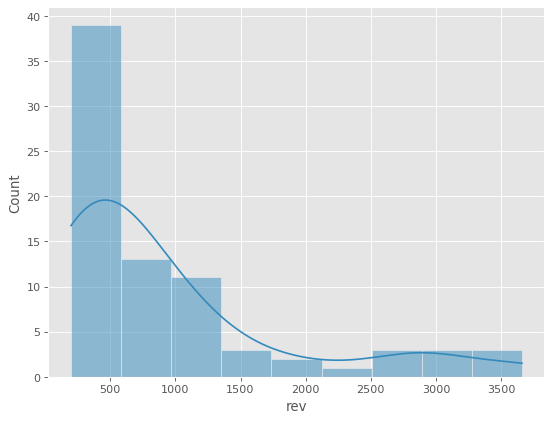

In [56]:
plt.figure(figsize=(8, 6), dpi=80)
sns.histplot(data = group_control_exp[group_control_exp['made_purchase'] == True], x='rev', kde=True)

<Figure size 400x300 with 0 Axes>

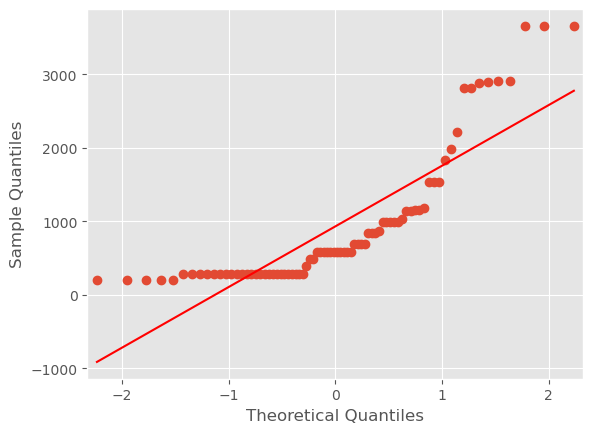

In [57]:
plt.figure(figsize = (8,6), dpi=50)
sm.qqplot(group_control_exp[group_control_exp['made_purchase'] == True].rev.values, line='r')
plt.show()

Попробуем прологарифмировать данные. Но, к сожалению, распределение все еще не нормальное

<Figure size 400x300 with 0 Axes>

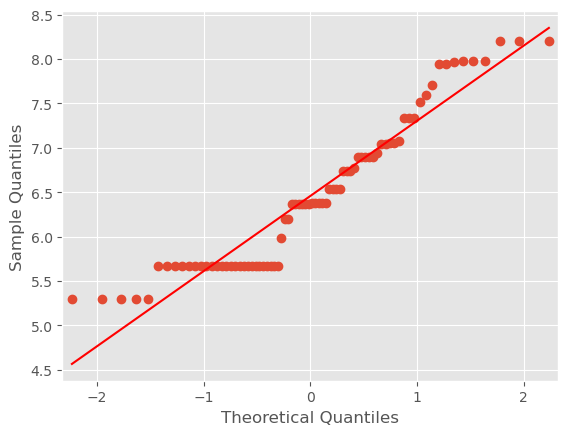

In [58]:
plt.figure(figsize = (8,6), dpi=50)
sm.qqplot(np.log(group_control_exp[group_control_exp['made_purchase'] == True].rev.values), line='r')
plt.show()

У тестовой группы распределение отличается от нормального. Это видно из графика распределения и qqplot'а

<AxesSubplot:xlabel='rev', ylabel='Count'>

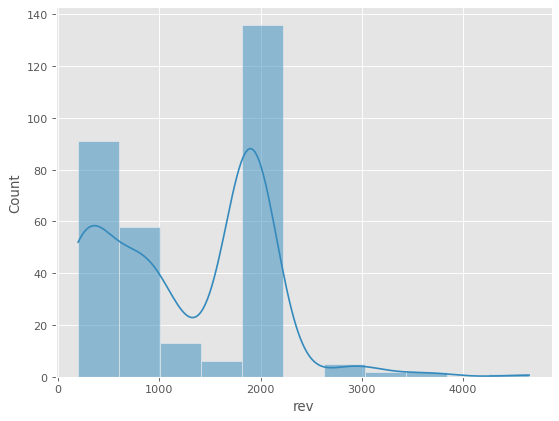

In [59]:
plt.figure(figsize=(8, 6), dpi=80)
sns.histplot(data = group_test_exp[group_test_exp['made_purchase'] == True], x='rev', kde=True)

<Figure size 400x300 with 0 Axes>

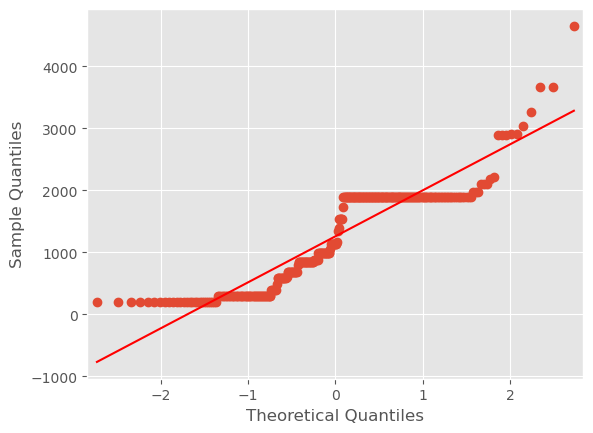

In [60]:
plt.figure(figsize = (8,6), dpi=50)
sm.qqplot(group_test_exp[group_test_exp['made_purchase'] == True].rev.values, line='r')
plt.show()

Также проверим распределение с помощью теста Агостино-Пирсона. Тест показал, что распределения отличаются от нормального

In [61]:
pg.normality(data=groups_merged[groups_merged['made_purchase'] == True], \
             dv='rev', group='grp', method='normaltest', alpha=0.05)

,W,pval,normal
grp,,,
A,52.218452,4.580439e-12,False
B,33.195875,6.188814e-08,False


#### Проверка гомогенности дисперсий

Проверим гомогенность дисперсий. Используем критерий Левена и тест Анова-Уэлча. Видим, что дисперсии двух различаются

In [62]:
pg.homoscedasticity(data=groups_merged[groups_merged['made_purchase'] == True], \
                    dv='rev', group='grp', method='levene', alpha=0.05)

,W,pval,equal_var
levene,4.478901,0.034774,False


In [63]:
pg.welch_anova(data=groups_merged[groups_merged['made_purchase'] == True], dv='rev', between='grp')

,Source,ddof1,ddof2,F,p-unc,np2
0,grp,1,152.06622,8.219795,0.004732,0.016822


#### Проверка на наличие выбросов

Посмотрим, имеются ли выбросы. Видим, что выбросы есть

Text(0, 0.5, 'Сумма заказов')

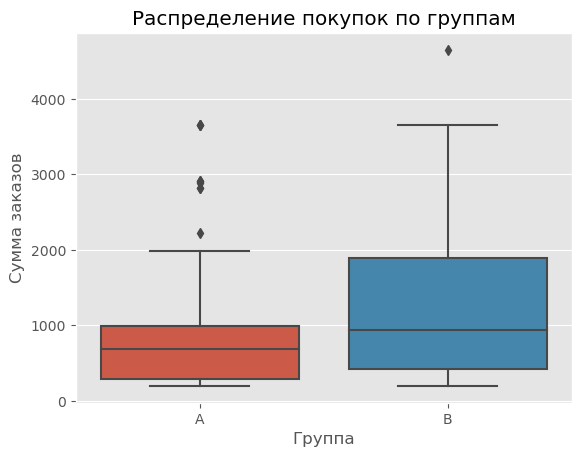

In [64]:
sns.boxplot(x = 'grp', y = 'rev', data = groups_merged[groups_merged['made_purchase'] == True])
plt.title('Распределение покупок по группам')
plt.xlabel('Группа')
plt.ylabel('Сумма заказов')

Text(0, 0.5, 'Сумма заказов')

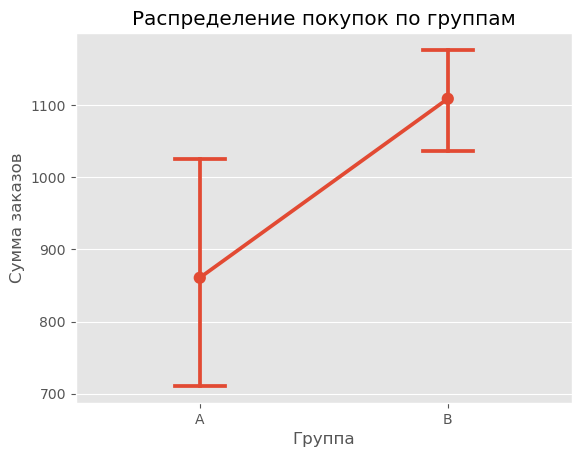

In [65]:
sns.pointplot(x = 'grp', y = 'rev', data = groups_merged[groups_merged['made_purchase'] == True], capsize = .2)
plt.title('Распределение покупок по группам')
plt.xlabel('Группа')
plt.ylabel('Сумма заказов')

Посчитаем значение максимума в данных, которое равно `75th percentile + 1.5 * IQR`, чтобы узнать значение, от которого мы будем отсчитывать выбросы. IQR - inner quartile range (75th percentile - 25th percentile).

In [66]:
(np.quantile(group_control_exp[group_control_exp['made_purchase'] == True].rev, 0.75) - \
np.quantile(group_control_exp[group_control_exp['made_purchase'] == True].rev, 0.25))*1.5 + \
np.quantile(group_control_exp[group_control_exp['made_purchase'] == True].rev, 0.75)

2351.875

In [67]:
(np.quantile(group_test_exp[group_test_exp['made_purchase'] == True].rev, 0.75) - \
np.quantile(group_test_exp[group_test_exp['made_purchase'] == True].rev, 0.25))*1.5 + \
np.quantile(group_test_exp[group_test_exp['made_purchase'] == True].rev, 0.75)

3982.375

Посчитаем количество выбросов

In [68]:
print('Кол-во выбросов контрольной группы:', \
      group_control_exp[group_control_exp['made_purchase'] == True].query('rev>2351.875').rev.count())
print('Кол-во выбросов тестовой группы:', \
      group_test_exp[group_test_exp['made_purchase'] == True].query('rev>3982.375').rev.count())

Кол-во выбросов контрольной группы: 9
Кол-во выбросов тестовой группы: 1


**Видим, что выбросов не так много. Если уберем их из данных, то распределение нормальным не станет. Поэтому убирать их из данных не будем.**

**Итак, исходя из того, что данные распределены не нормально и дисперсии двух групп отличаются, то t-критерий для независимых выборок применить не получится. Для проверки нулевой гипотезы и оценки статистической значимости результатов эксперимента необходимо использовать непараметрические тесты (U-критерий Манна-Уитни - непараметрический аналог Т-теста, bootstrap)**

### 7) Сравнение среднего чека двух групп 

Итак, сформируем H0 и H1.

**H0: средний чек двух групп значимо не отличается \
H1: средний чек двух групп значимо отличается**

Проведем проверку, используя непараметрический аналог Т-теста - Тест Манна-Уитни и тест Bootstrap.

**U-критерий Манна-Уитни**

Тест Манна-Уитни переводит все данные в ранговую шкалу (ранжирует показатели от 1 до последнего), после этого считает какой средний ранг оказался в первой группе и какой во второй. Этот критерий менее чувствителен к экстремальным отклонениям от нормальности и наличию выбросов.

Тест Манна-Уитни проверяет гипотезу о равенстве распределений. Что значит равенство распределений? Это значит, что случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки.

Манн-Уитни как и любой статистический оценщик не очень приветлив к дисбалансу. Это сказывается в первую очередь на мощности критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу 

Итак, видим, что p-value < 0.05, значит распределения в группах статистически значимо различаются

In [69]:
ss.mannwhitneyu(group_control_exp[group_control_exp['made_purchase'] == True].rev, \
                         group_test_exp[group_test_exp['made_purchase'] == True].rev)

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

**Bootstrap**

Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики, в нашем случае - значение среднего чека подвыборки

Затем из среднего подвыборки тестовой группы вычитается среднее подвыборки контрольной группы и записывается в датафрейм

Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [70]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

Построим распределение данных. Видим, что данные распределены нормально (что не удивительно, так как мы извлекали 2000 раз подвыборки и возвращали значения обратно в наши тестовую и контрольную выборки, считали среднее подвыборок и записывали значения разницы этих средних, что и позволило нам получить нормальное распределение согласно ЦПТ) 

  0%|          | 0/2000 [00:00<?, ?it/s]

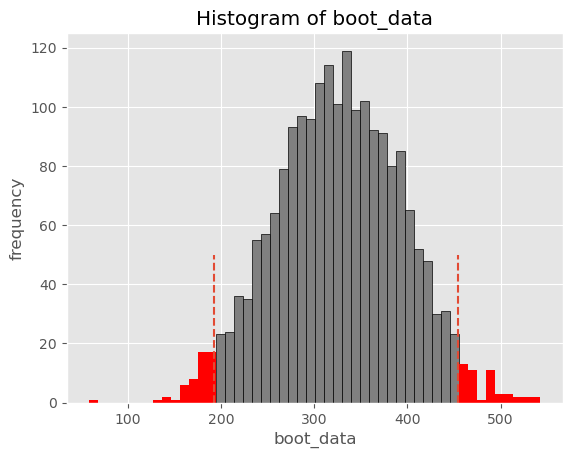

In [71]:
booted_data = get_bootstrap(
    group_test_exp[group_test_exp['made_purchase'] == True].rev, # числовые значения первой выборки
    group_control_exp[group_control_exp['made_purchase'] == True].rev # числовые значения второй выборки
)

**Итак, p-value < 0.05, что позволяет нам отклонить H0 гипотезу и принять H1 гипотезу о том, что значения среднего чека двух групп различаются.**

In [72]:
booted_data["p_value"]

1.4627428950178826e-06

**Также видно, что значение 0 не попадает в ДИ, что тоже позволяет отклонить H0**

In [73]:
booted_data["quants"]

,0
0.025,192.916893
0.975,454.303118


Проведем еще раз bootstrap, но с подсчетом другой статистики - медианы

In [74]:
def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x = 0, 
        loc = np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x = 0, 
        loc = -np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

Видим, что данные распределены не нормально, что не позволяет использовать данную статистику при определении статистической значимости различий средних

  0%|          | 0/2000 [00:00<?, ?it/s]

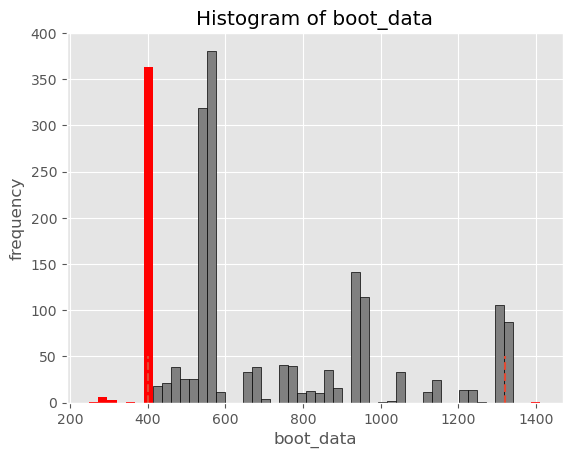

In [75]:
booted_data_median = get_bootstrap_median(group_test_exp[group_test_exp['made_purchase'] == True].rev, # числовые значения первой выборки
                    group_control_exp[group_control_exp['made_purchase'] == True].rev # числовые значения второй выборки
                    )

### 8) Сравнение CR двух групп 

Для того, чтобы понять взаимосвязаны ли два номинальных (дискретных) признака (группа - А/Б и факт покупки - купил/не купил), необходимо применить критерий Хи-квадрат. Другими словами, с помощью Хи-квадрат можно проверить, есть ли взаимосвязь между группой и количеством покупок. 

Хи-квадрат проверяет гипотезу о различии распределения выборки от ожидаемого. То есть отличаются ли наблюдаемые значения (observed) в таблице сопряженности от ожидаемых значений (expected). Если отличия распределения выборки от ожидаемого статистически значимо, то номинативные переменные (группа и факт покупки) взаимосвязаны между собой.

Датафрейм, который будем использовать

In [81]:
groups_merged[groups_merged['exp_participated'] == 1].head()

,id,grp,exp_participated,rev,made_purchase
1,1627,A,1.0,990.0,True
10,2085,B,1.0,0.0,False
12,2215,B,1.0,0.0,False
43,3391,A,1.0,0.0,False
45,3401,B,1.0,0.0,False


Составим нулевую и альтенативную гипотезу: \
**H0: взаимосвязи между двумя номинативными признаками нет** \
**H1: взаимосвязь между двумя номинативными признаками есть**

Составим таблицу сопряженности для подсчета статистики Хи квадрат. Итак, мы получили observed значения для проведения теста

In [88]:
observed_values = pd.crosstab(index = groups_merged[groups_merged['exp_participated'] == 1].grp, \
            columns = groups_merged[groups_merged['exp_participated'] == 1].made_purchase)

In [89]:
observed_values

made_purchase,False,True
grp,,
A,1460,78
B,6489,314


С помощью теста определим статистику Хи-квадрат и величину p-value, которая нам покажет вероятность получить такие или еще более выраженные отклонения при верности нулевой гипотезы. Expected значения посчитаются автоматически с помощью метода библиотеки scipy

In [92]:
chi2, prob, df, expected = ss.chi2_contingency(observed_values, correction=True)

Итак, видим, что значение p-value > 0.05, значит нет оснований отклонить нулевую гипотезу о том, что взимосвязи между группой и количеством совершенных покупок нет

In [96]:
print(f'statictics: {chi2}\np_value: {prob}\ndegrees of freedom: {df}\nexpected values:\n {expected}')

statictics: 0.48480826522557896
p_value: 0.48625240457231045
degrees of freedom: 1
expected values:
 [[1465.71897854   72.28102146]
 [6483.28102146  319.71897854]]


## Вывод:
**1) Bootstrap показал, что значения среднего чека двух групп отличаются статистически значимо.** \
AVG Check of experiment days: \
Control Group = 933.59 \
Test Group = 1257.88

**2) Критерий Хи-квадрат показал, что количество совершенных покупок статистически значимо не отличается между контрольной и тестовой группой.** \
CR of experiment days: \
Control Group = 5.07 \
Test Group = 4.62

Следовательно, показатель конверсии CR = buyers / users (где buyers = orders, так как каждый покупатель совершил только одну покупку) не зависит от группы. Фактом снижения CR в тестовой группе можно пренебречь.


**Таким образом, можно сделать вывод, что применение новой механики оплаты услуг на сайте (тестовая группа) целесообразоно, так как это увеличивает метрику среднего чека, хотя и не влияет на конверсию.**

# Задание 2. SQL

## 2.1 Очень усердные ученики.

### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин за час.

### 2.1.2 Задача

Дана таблица peas:

st_id - ID ученика \
timest - Время решения карточки \
correct - Правильно ли решена горошина? \
subject - Дисциплина, в которой находится горошина

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за октябрь 2021 года.

```
SELECT count(distinct st_id) as diligent_students_number  
FROM(  
    SELECT st_id,  
            toHour(timest) as hour,  
            toDayOfMonth(timest) as day,  
            count(correct) as correct_solutions  
     FROM peas  
     WHERE toStartOfMonth(timest) = '2021-10-01' and correct = 1  
     GROUP BY st_id, day, hour) t1  
WHERE correct_solutions >= 20
```

## 2.2 Оптимизация воронки

### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### 2.2.2 Задача

**Даны:**

таблица peas:

- st_id - ID ученика
- timest - Время решения карточки
- correct - Правильно ли решена горошина?
- subject - Дисциплина, в которой находится горошина

таблица studs:
- st_id - ID ученика
- test_grp - Метка ученика в данном эксперименте

таблица checks:
- st_id - ID ученика
- sale_time - Время покупки
- money - Цена, по которой приобрели данный курс
- subject - Дисциплина, на которую приобрели полный доступ

**Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:**
- ARPU
- ARPAU
- CR в покупку
- СR активного пользователя в покупку
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

```
SELECT
    t1.test_grp AS group,
    ROUND(revenue/all_users, 2) AS ARPU,
    ROUND(revenue/active_users, 2) AS ARPAU,
    ROUND(100*paid_users/all_users, 2) AS CR,
    ROUND(100*active_paid_users/active_users, 2) AS active_user_CR,
    ROUND(100*math_buyers/math_active_students, 2) AS CR_math
FROM(
    SELECT
        test_grp,
        SUM(money) AS revenue,
        COUNT(DISTINCT f.st_id) filter(WHERE money > 0) AS paid_users
    FROM 
        studs AS s
    LEFT JOIN
        final_project_check AS f
    ON s.st_id = f.st_id
    GROUP BY
        test_grp) AS t1 -- выручка + общее число покупателей
-----------------------
LEFT JOIN
    (SELECT
        test_grp,
        COUNT(DISTINCT s.st_id) filter(WHERE) AS active_users,
        COUNT(DISTINCT s.st_id) AS all_users
    FROM
        peas AS p
    LEFT JOIN
        studs AS s
    ON s.st_id = p.st_id
    GROUP BY
        test_grp) AS t2 -- все юзеры и активные юзеры
USING(test_grp)
-----------------------
LEFT JOIN
    (SELECT
        test_grp,
        COUNT(DISTINCT f.st_id) filter(WHERE correct = 1) AS active_paid_users,
        COUNT(DISTINCT p.st_id) filter(WHERE p.subject = 'Math') AS math_active_students,
        COUNT(DISTINCT f.st_id) filter(WHERE p.subject = 'Math') AS math_buyers
    FROM
        peas AS p
    LEFT JOIN
        default.final_project_check AS f
    ON p.st_id = f.st_id and p.subject = f.subject
    LEFT JOIN
        studs AS s
    ON p.st_id = s.st_id
    GROUP BY
        test_grp) AS t3      -- активные юзеры, совершившые покупку, + активные юзеры курса по мат-ке,
ON t1.test_grp = t3.test_grp -- плюс покупатели курса по математике
```

## Задание 3. Python

### 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

#### 1. Функция для загрузки дополнительного файла и пересчета метрик

Создадим переменную public_key_add, куда будем помещать ссылку с новым файлом groups_add

In [198]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'

Получаем url для загрузки файла

In [199]:
final_url_add = base_url + urlencode(dict(public_key=public_key_add)) 
response_add = requests.get(final_url_add)
download_url_add = response_add.json()['href']

Загружаем датафрейм

In [230]:
download_response = requests.get(download_url_add)
new_file = pd.read_csv(download_url_add)

Создаем функцию

In [393]:
def new_data(groups, new_file, active_studs, checks):

    # так как название колонок может отличатся, то приводим колонки к нужному нам виду     
    new_file.rename(columns = {new_file.columns[0]:'id', new_file.columns[1]:'grp'}, inplace = True)
    active_studs.rename(columns = {active_studs.columns[0]:'id', active_studs.columns[1]:'exp'}, inplace = True)
    checks.rename(columns = {checks.columns[0]:'id'}, inplace = True)
    
    # избавляемся от дупликатов, если они есть
    groups.drop_duplicates(subset = ['id'], inplace=True)
    new_file.drop_duplicates(subset = ['id'], inplace=True)
    active_studs.drop_duplicates(subset = ['id'], inplace=True)
    checks.drop_duplicates(subset = ['id'], inplace=True)
    
    # дропаем отсутствующие значения
    new_file.dropna(inplace = True)
    groups.dropna(inplace = True)
    active_studs.dropna(inplace = True)
    checks.dropna(inplace = True)
    
    # приводим данные к нужному типу
    new_file = new_file.astype({'id':'int64', 'grp':'string'})
    groups = groups.astype({'id':'int64', 'grp':'string'})
    active_studs = active_studs.astype({'id':'int64', 'exp':'int8'})
    checks = checks.astype({'id':'int64', 'rev':'int32'})
    
    # добавим данные из нового датафрейма в df groups
    groups_all = pd.concat([groups, new_file], ignore_index=True, axis=0).drop_duplicates()
    
    # джоиним active_studs с checks и groups_all для создания датафрейма с данными эксперимента
    exp_final_data = active_studs \
    .merge(groups_all, how='inner', on='id').fillna(0) \
    .merge(checks, how='left', on='id').fillna(0)
    
    # считаем метрики
    final_data = exp_final_data.groupby(['grp'], as_index=False).agg({'rev':'sum'}) \
              .rename(columns={'rev':'revenue'})
    
    final_data['customers'] = exp_final_data.query('rev > 0').groupby(['grp'], as_index=False) \
                .agg({'id':'nunique'}).rename(columns={'id':'customers'}).customers
    
    final_data['users'] = exp_final_data.groupby(['grp'], as_index=False) \
            .agg({'id':'nunique'}).rename(columns={'id':'users'}).users
    
    final_data['orders'] = exp_final_data.query('rev > 0').groupby(['grp'], as_index=False) \
             .agg({'id':'count'}).rename(columns={'id':'orders'}).orders
    
    final_data['avg_check'] = final_data['revenue']/final_data['orders']
    final_data['ARPU'] = final_data['revenue']/final_data['users']
    final_data['ARPPU'] = final_data['revenue']/final_data['customers']
    final_data['CR'] = final_data['customers']/final_data['users']*100
    
    return final_data

In [394]:
updated_metrics = new_data(groups, new_file, active_studs, checks)
updated_metrics

,grp,revenue,customers,users,orders,avg_check,ARPU,ARPPU,CR
0,A,72820.0,78,1538,78,933.589744,47.347204,933.589744,5.071521
1,B,394974.0,314,6803,314,1257.878981,58.058798,1257.878981,4.615611


#### 2. Функция, которая будет строить графики по получаемым метрикам.

Создаем функцию

In [412]:
def graphs(exp_final_data, updated_metrics):
    
    # создаем фигуру и набор графиков для распределения количества покупок по группам.
    # задаем размер графиков и количество строк, столбцов сетки графиков
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # распределение количества покупок по группам
    sns.histplot(data = exp_final_data.query('grp == "A" & rev > 0'), x='rev', ax=axes[0], color='blue')
    sns.histplot(exp_final_data.query('grp == "B" & rev > 0'), x='rev', ax=axes[1], color='red')
    axes[0].set(title='Покупки, группа А', xlabel='checks')
    axes[1].set(title='Покупки, группа B', xlabel='checks')
    
    # создаем фигуру и набор графиков для отображения метрик по группам.
    # задаем размер графиков и количество строк, столбцов сетки графиков
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    # графики метрик
    sns.barplot(x='grp', y='avg_check', data=updated_metrics, ax=axes[0], palette="Paired")
    axes[0].set(title='Средний чек', xlabel='groups')
    #plt.tight_layout(w_pad=2)

    sns.barplot(x='grp', y='CR', data=updated_metrics, ax=axes[1], palette="Paired")
    axes[1].set(title='Конверсия в покупку', xlabel='groups')
    
    # создаем фигуру и набор графиков для отображения метрик по группам.
    # задаем размер графиков и количество строк, столбцов сетки графиков
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # графики метрик
    sns.barplot(x='grp', y='ARPU', data=updated_metrics, ax=axes[0], palette="Paired")
    axes[0].set(title='ARPU', xlabel='groups')
    
    sns.barplot(x='grp', y='orders', data=updated_metrics, ax=axes[1], palette="Paired")
    axes[1].set(title='Количество покупок', xlabel='groups')
    
    plt.show()

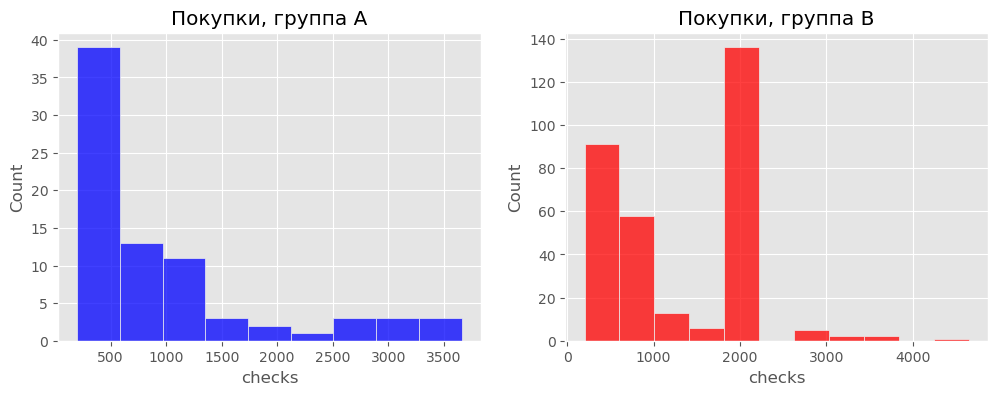

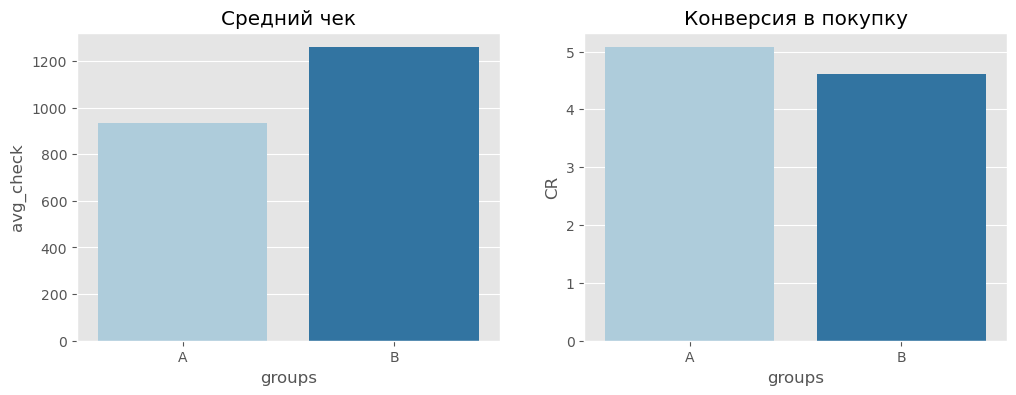

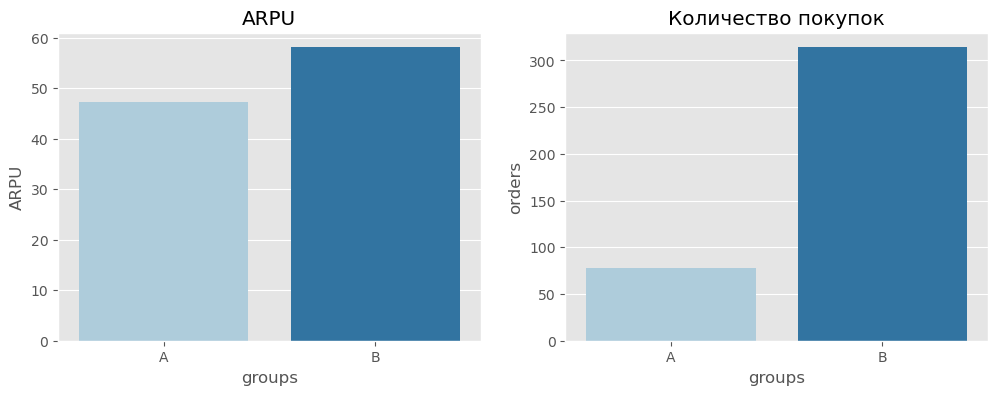

In [413]:
graphs(exp_final_data, updated_metrics)